<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-Pruning" data-toc-modified-id="Model-Pruning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model Pruning</a></span><ul class="toc-item"><li><span><a href="#Magnitude-Weight-pruning" data-toc-modified-id="Magnitude-Weight-pruning-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Magnitude Weight pruning</a></span></li></ul></li><li><span><a href="#Modeling-Approach-:-Transfer-learning" data-toc-modified-id="Modeling-Approach-:-Transfer-learning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling Approach : Transfer learning</a></span></li><li><span><a href="#Global-pruning" data-toc-modified-id="Global-pruning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Global pruning</a></span><ul class="toc-item"><li><span><a href="#Sparsity-after-pruning" data-toc-modified-id="Sparsity-after-pruning-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Sparsity after pruning</a></span></li></ul></li><li><span><a href="#Fine-tuning-using-the-pruned-model" data-toc-modified-id="Fine-tuning-using-the-pruned-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fine tuning using the pruned model</a></span></li></ul></div>

# Сжатие модели

Глубокие нейронные сети являются самыми современными моделями для многих задач, особенно с неструктурированными данными, такими как изображения, текст и т.д. Одна из проблем моделей глубокого обучения заключается в том, что они сильно перегружены параметрами, что затрудняет их развертывание / использование на устройствах с низкими требованиями к памяти. Сжатие модели нейронных сетей без ущерба для производительности модели является активной темой исследований в области машинного обучения. Сокращение параметров, квантование, дистилляция знаний и т.д. - широко используемые в настоящее время подходы для придания нейронным сетям компактности. В этом блокноте мы продемонстрируем технику обрезки параметров на точно настроенной модели Resnet50.

## Обрезка модели

Сокращение - это метод, используемый для уменьшения избыточных параметров, которые не чувствительны к производительности. Одним из способов уменьшения параметров во время обучения является использование регуляризации L-1. Но при использовании регуляризации L1 нет особого контроля над количеством параметров, которые необходимо сократить. Были и более ранние работы по глубокому обучению, в которых опробовались различные методы обрезки, например, Ян Ле Кун и др., в статье [**Оптимальный мозг Damage**](https://proceedings.neurips.cc/paper/1989/hash/6c9882bbac1c7093bd25041881277658-Abstract.html). В работе была предпринята попытка уменьшить количество соединений на основе гессиана функции потерь. В настоящее время существуют различные методы обрезки нейронных сетей. Существуют подходы, которые учитывают разреженность при обучении модели, такие как [** гипотеза выигрышного лотерейного билета**](https://arxiv.org/abs/1803.03635) и более аппаратно-эффективные методы сокращения, такие как [**N:M Мелкозернистых структурированных разреженных нейронных сетей**](https://arxiv.org/abs/2102.04010). В его записной книжке мы продемонстрируем гораздо более простой метод обрезки, называемый ** обрезка по величине веса.**

### Обрезка по величине веса

Ссылка : https://arxiv.org/pdf/1506.02626.pdf

В методе сокращения веса по величине веса веса, основанные на желаемом уровне разреженности, удаляются из нейронной сети после обучения. Предполагается, что важны веса с большими абсолютными значениями. При сокращении величины, если мы хотим разреженность 'X%', мы сокращаем меньшие веса на основе абсолютного значения для достижения желаемой разреженности. Это может быть сделано на уровне слоев (локально) или для всей модели (глобально). Выполняя глобальную обрезку, необходимо убедиться, что не все веса в одном слое обрезаны, что влияет на послойную связь в нейронной сети. Чтобы улучшить производительность модели, модель часто корректируется с учетом существующих весовых коэффициентов. Если этот процесс выполняется итеративно, он называется "**итеративное сокращение величины**". Существует много различных способов уменьшения весов, таких как обрезка на основе шаблонов, обрезка на основе векторов, обрезка на уровне векторов, обрезка на уровне ядра, обрезка на уровне каналов и т.д., но они выходят за рамки этой тетради. Чтобы сделать обрезку эффективной и аппаратно рациональной, возможно, придется использовать некоторые из этих методов обрезки, а не простую обрезку, основанную на величине.



# Постановка задачи
Это задача классификации изображений по нескольким классам. Данные содержат изображения из 6 категорий "здания", "лес", "ледник", "гора", "море", "улица". Цель состоит в разработке модели машинного обучения, которая корректно классифицирует входное изображение по одной из категорий.

В этом блокноте мы пытаемся найти модель с фиксированным процентом разреженности, не теряя при этом выразительности исходной плотной модели.

## Подход к моделированию: Трансферное обучение

Ссылка : https://www.kaggle.com/code/darraghcaffrey/transfer-learning-with-resnet50-91-5-test-acc <br>
https://arxiv.org/abs/1512.03385

Мы используем предварительно обученную модель Resnet-50 и проводим точную настройку на наборе обучающих программ.

## Скачивание датасета

In [ ]:
pip install torchutils

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import cv2
import os
import torchutils as tu
import torch
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import json

from PIL import Image
from torch import optim
from torch.autograd import Variable
from torch.utils.data import random_split, DataLoader
from torch import nn
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets
from torchvision import io
import time

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nastasiamozhayskaya","key":"8749423897202389c57f49e50b8c08e6"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

100% 346M/346M [00:11<00:00, 26.3MB/s]
100% 346M/346M [00:11<00:00, 31.7MB/s]


In [ ]:
!unzip /content/intel-image-classification.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train

In [ ]:
train_dir = "/content/seg_train/seg_train"
test_dir = "/content/seg_test/seg_test"
pred_dir ="/content/seg_pred/seg_pred"


pred_files = [os.path.join(pred_dir, f) for f in os.listdir(pred_dir)]

In [ ]:
cat_counts = {}
for cat in os.listdir(train_dir):
    counts = len(os.listdir(os.path.join(train_dir, cat)))
    cat_counts[cat] = counts
print(cat_counts)

{'street': 2382, 'mountain': 2512, 'buildings': 2191, 'sea': 2274, 'forest': 2271, 'glacier': 2404}


In [ ]:
# mean и std, для которых Resnet был обучен на
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:
# Torchvision train and test transforms
train_transforms = transforms.Compose([T.Resize((150, 150)), # Resize all images
                                       T.RandomResizedCrop(150),# Crop
                                       T.RandomRotation(30), # Rotate
                                       T.RandomHorizontalFlip(), # Flip
                                       T.ToTensor(), # Convert
                                       T.Normalize(torch.Tensor(mean), torch.Tensor(std)) # Normalize
                                       ])



test_transforms = transforms.Compose([T.Resize((150, 150)),
                                     T.CenterCrop(150),
                                     T.ToTensor(),
                                     T.Normalize(torch.Tensor(mean),torch.Tensor(std))
                                     ])

## Разделения трейнового набора с изображениями трейн и валид

In [ ]:
# Папку с изображениями разделим на трейн и валид
tmp_data = datasets.ImageFolder(train_dir, transform=train_transforms)
print("Количество файлов в tmp_data:", len(tmp_data))

Количество файлов в tmp_data: 14034


In [ ]:
# Случайное разбиение tmp_data на основе длины набора данных и заданного начального значения для воспроизводимого разбиения
train_data, val_data = random_split(tmp_data, [10000, 4034], generator=torch.Generator().manual_seed(42))
print("Количество файлов в train_data:", len(train_data))
print("Количество файлов в val_data:", len(val_data))

Количество файлов в train_data: 10000
Количество файлов в val_data: 4034


In [ ]:
# Тестовый набор
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

### Словарь с классами

In [ ]:
idx6class = {j: i for i, j in tmp_data.class_to_idx.items()}
idx6class

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [ ]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Загрузка модели ResNet50

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.DEFAULT) # где DEFAULT - лучшие последние веса
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Тестирование модели

In [ ]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2023-11-24 18:53:16--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.103.16, 16.182.74.160, 52.217.117.184, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.103.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.09s   

2023-11-24 18:53:16 (403 KB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



In [ ]:
!head imagenet_class_index.json

{"0": ["n01440764", "tench"], "1": ["n01443537", "goldfish"], "2": ["n01484850", "great_white_shark"], "3": ["n01491361", "tiger_shark"], "4": ["n01494475", "hammerhead"], "5": ["n01496331", "electric_ray"], "6": ["n01498041", "stingray"], "7": ["n01514668", "cock"], "8": ["n01514859", "hen"], "9": ["n01518878", "ostrich"], "10": ["n01530575", "brambling"], "11": ["n01531178", "goldfinch"], "12": ["n01532829", "house_finch"], "13": ["n01534433", "junco"], "14": ["n01537544", "indigo_bunting"], "15": ["n01558993", "robin"], "16": ["n01560419", "bulbul"], "17": ["n01580077", "jay"], "18": ["n01582220", "magpie"], "19": ["n01592084", "chickadee"], "20": ["n01601694", "water_ouzel"], "21": ["n01608432", "kite"], "22": ["n01614925", "bald_eagle"], "23": ["n01616318", "vulture"], "24": ["n01622779", "great_grey_owl"], "25": ["n01629819", "European_fire_salamander"], "26": ["n01630670", "common_newt"], "27": ["n01631663", "eft"], "28": ["n01632458", "spotted_salamander"], "29": ["n01632777", 

In [ ]:
# делаем словарь, чтобы по индексу найти название класса
labels = json.load(open('/content/imagenet_class_index.json'))
# функция декодировки
decode = lambda x: labels[str(x)][1]
decode(300)

'tiger_beetle'

In [ ]:
# скачаем картинку для теста
!wget -O image.jpg https://kopiberi.ru/uploads/images/feature_image/a7132da6-b853-4ee4-892e-ec682f9eb752.jpeg

--2023-11-24 18:43:16--  https://kopiberi.ru/uploads/images/feature_image/a7132da6-b853-4ee4-892e-ec682f9eb752.jpeg
Resolving kopiberi.ru (kopiberi.ru)... 195.161.62.131
Connecting to kopiberi.ru (kopiberi.ru)|195.161.62.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414199 (404K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 404.49K  2.44MB/s    in 0.2s    

2023-11-24 18:43:16 (2.44 MB/s) - ‘image.jpg’ saved [414199/414199]



In [ ]:
resize = T.Resize((150, 150))

In [ ]:
img = resize(io.read_image('image.jpg')/255)
img.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 150, 150])

In [ ]:
img.unsqueeze(0).shape

torch.Size([1, 3, 150, 150])

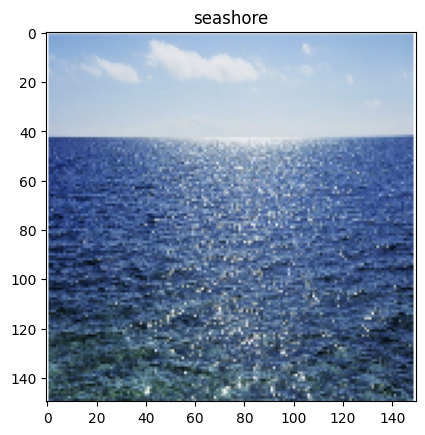

In [ ]:
# весь тест в 4 строки
model.to(device)
model.eval()
plt.imshow(torch.permute(img, (1, 2, 0)))
plt.title(decode(model(img.to(device).unsqueeze(0)).argmax().item()));

### Разморозка последнего слоя модели ResNet50

In [ ]:
model.fc = nn.Linear(2048, 6)

In [ ]:
model.to(device)
tu.get_model_summary(model, torch.randn(1, 3, 150, 150, device=device))

Layer                                         Kernel              Output          Params          FLOPs
0_conv1                                      [3, 64, 7, 7]     [1, 64, 75, 75]       9,408   52,920,000
1_bn1                                                 [64]     [1, 64, 75, 75]         128    1,440,000
2_relu                                                   -     [1, 64, 75, 75]           0            0
3_maxpool                                                -     [1, 64, 38, 38]           0            0
4_layer1.0.Conv2d_conv1                     [64, 64, 1, 1]     [1, 64, 38, 38]       4,096    5,914,624
5_layer1.0.BatchNorm2d_bn1                            [64]     [1, 64, 38, 38]         128      369,664
6_layer1.0.ReLU_relu                                     -     [1, 64, 38, 38]           0            0
7_layer1.0.Conv2d_conv2                     [64, 64, 3, 3]     [1, 64, 38, 38]      36,864   53,231,616
8_layer1.0.BatchNorm2d_bn2                            [64]     [

In [ ]:
# проверяем, какие параметры обучаемые
# for p in model.parameters():
#     print(p.requires_grad)

In [ ]:
# замораживаем все веса в модели кроме последнего слоя
for param in model.parameters():
    param.requires_grad = False

model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

model.to(device);

## Обучение модели

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

In [ ]:
def fit(model: torch.nn.Module, n_epochs: int = 10):
    """Function to fit model

    Returns:
        Dict called "history", having next keys:
            train_losses: list of train losses per epoch
            valid_losses: list of valid losses per epoch
            train_acc: list of train accuracy per epoch
            valid_acc: list of valid accuracy per epoch
    """

    history = {
        'train_losses': [],
        'valid_losses': [],
        'train_acc': [],
        'valid_acc': []
    }
    model.to(device)
    for epoch in range(1, n_epochs+1):
        start_time = time.time()
        model.train()
        train_losses = []
        train_acc = []
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            # print(prediction)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            accuracy = (preds == labels).sum() / BATCH_SIZE

            train_losses.append(loss.item())
            train_acc.append(accuracy.detach().cpu().numpy())

        valid_losses = []
        valid_acc = []
        model.eval()
        for images, labels in valid_loader:

            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
              outputs = model(images)

            preds = torch.argmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            accuracy = (preds == labels).sum() / BATCH_SIZE

            valid_acc.append(accuracy.detach().cpu().numpy())
            valid_losses.append(loss.item())

        history['train_losses'].append(np.mean(train_losses))
        history['valid_losses'].append(np.mean(valid_losses))
        history['train_acc'].append(np.mean(train_acc))
        history['valid_acc'].append(np.mean(valid_acc))

        if epoch % 1 == 0:
            print(f" Epoch number - {epoch}: train metric: {history['train_acc'][-1]:.3f}, train loss: {history['train_losses'][-1]:.3f}, time: {(time.time() - start_time):.1f}s")
            print(f" Epoch number - {epoch}: valid metric: {history['valid_acc'][-1]:.3f}, valid loss: {history['valid_losses'][-1]:.3f}, time: {(time.time() - start_time):.1f}s")
            print('-' * 71)

    return history

In [ ]:
history = fit(model, 5)

 Epoch number - 1: train metric: 0.838, train loss: 0.426, time: 51.9s
 Epoch number - 1: valid metric: 0.812, valid loss: 0.499, time: 51.9s
---------------------------------------------------------------
 Epoch number - 2: train metric: 0.832, train loss: 0.446, time: 49.7s
 Epoch number - 2: valid metric: 0.804, valid loss: 0.527, time: 49.7s
---------------------------------------------------------------
 Epoch number - 3: train metric: 0.842, train loss: 0.428, time: 50.5s
 Epoch number - 3: valid metric: 0.822, valid loss: 0.486, time: 50.5s
---------------------------------------------------------------
 Epoch number - 4: train metric: 0.839, train loss: 0.432, time: 50.1s
 Epoch number - 4: valid metric: 0.812, valid loss: 0.511, time: 50.1s
---------------------------------------------------------------
 Epoch number - 5: train metric: 0.842, train loss: 0.441, time: 51.2s
 Epoch number - 5: valid metric: 0.816, valid loss: 0.510, time: 51.2s
----------------------------------

In [ ]:
# зададим функцию рисования графиков
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,5))

    ax[0].plot(history['train_losses'], label='train loss')
    ax[0].plot(history['valid_losses'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0].grid(grid)
    ax[0].legend()

    ax[1].plot(history['train_acc'], label='train acc')
    ax[1].plot(history['valid_acc'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_losses"])}')
    ax[1].grid(grid)
    ax[1].legend()

    plt.show()

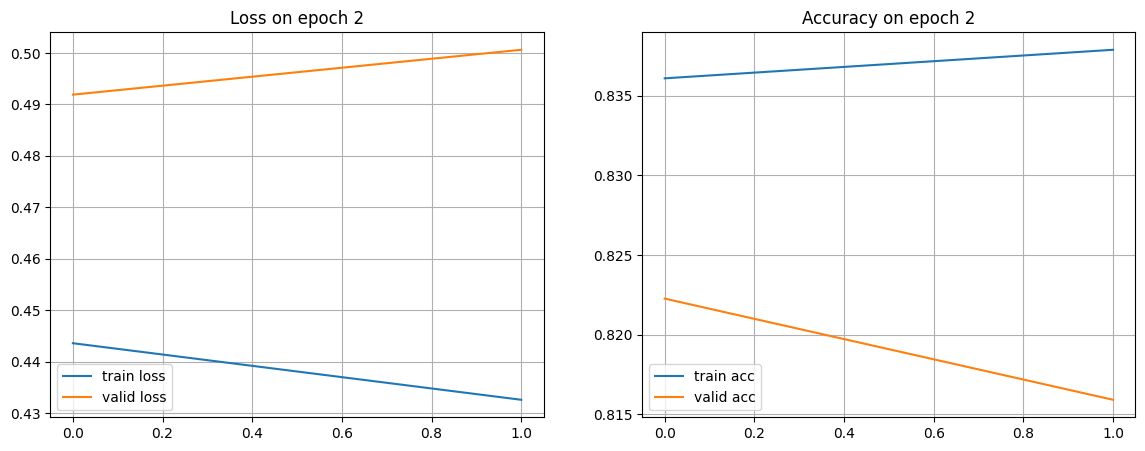

In [ ]:
plot_history(history)

### Проверка модели ResNet50

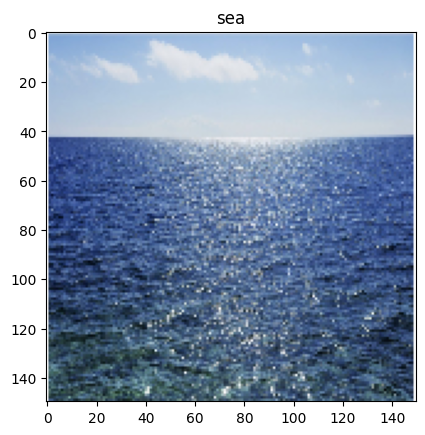

In [ ]:
# весь тест в 4 строки
model.to(device)
model.eval()
plt.imshow(torch.permute(img, (1, 2, 0)))
plt.title(idx6class[model(img.to(device).unsqueeze(0)).argmax().item()]);

### Cохранение весов хорошей модели

In [ ]:
torch.save(model.state_dict(), '6classes_ResNet50.pt')